In [1]:
import pandas as pd
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
base_path = "/content/drive/MyDrive/Okul/İTÜ/Bilgisayar Mühendisliği Yüksek Lisans/Yüksek Lisans/YL Tez/Development/Bot-Iot"
X_train = np.genfromtxt(f"{base_path}/Sampled/30-sampled-x-train.csv", delimiter=',')
y_train = np.genfromtxt(f"{base_path}/Sampled/30-sampled-y-train.csv", delimiter=',')
X_test = np.genfromtxt(f"{base_path}/Sampled/30-sampled-x-test.csv", delimiter=',')
y_test = np.genfromtxt(f"{base_path}/Sampled/30-sampled-y-test.csv", delimiter=',')

In [4]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = y_train.astype("int64")
y_test = y_test.astype("int64")

num_classes = len(np.unique(y_train))

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

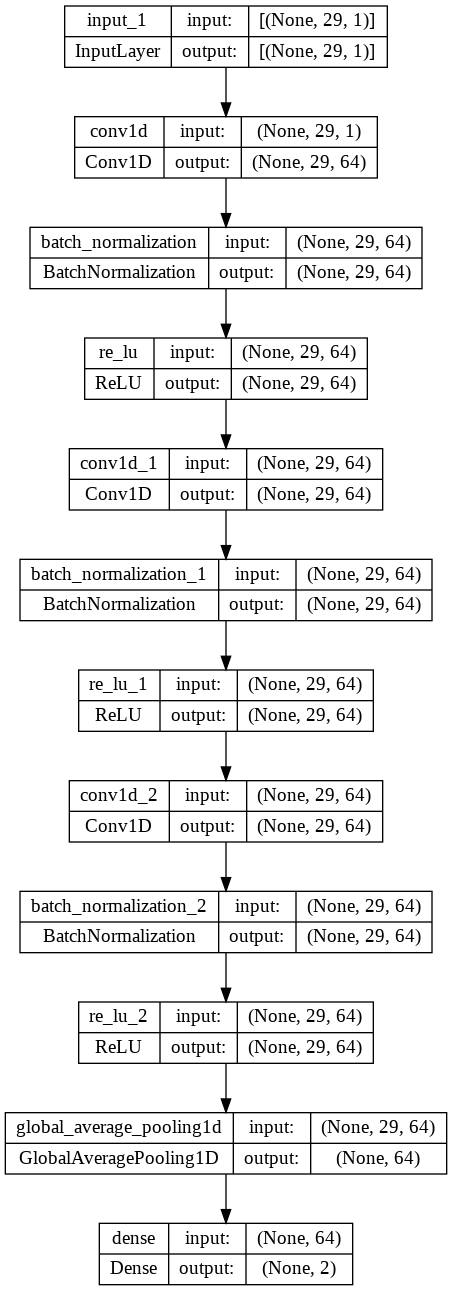

In [5]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=X_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)


In [6]:
epochs = 100
batch_size = 10

callbacks = [
    keras.callbacks.ModelCheckpoint(
        f"{base_path}/Model/rnn-time-series-best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/100
635/635 [==============================] - 10s 12ms/step - loss: 0.1483 - sparse_categorical_accuracy: 0.9570 - val_loss: 0.0720 - val_sparse_categorical_accuracy: 0.9880 - lr: 0.0010
Epoch 2/100
635/635 [==============================] - 5s 9ms/step - loss: 0.0523 - sparse_categorical_accuracy: 0.9852 - val_loss: 0.0359 - val_sparse_categorical_accuracy: 0.9855 - lr: 0.0010
Epoch 3/100
635/635 [==============================] - 5s 7ms/step - loss: 0.0415 - sparse_categorical_accuracy: 0.9891 - val_loss: 0.0217 - val_sparse_categorical_accuracy: 0.9943 - lr: 0.0010
Epoch 4/100
635/635 [==============================] - 5s 8ms/step - loss: 0.0330 - sparse_categorical_accuracy: 0.9915 - val_loss: 0.0221 - val_sparse_categorical_accuracy: 0.9937 - lr: 0.0010
Epoch 5/100
635/635 [==============================] - 5s 8ms/step - loss: 0.0274 - sparse_categorical_accuracy: 0.9928 - val_loss: 0.0360 - val_sparse_categorical_accuracy: 0.9912 - lr: 0.0010
Epoch 6/100
635/635 [=======

In [7]:
model = keras.models.load_model(f"{base_path}/Model/rnn-time-series-best_model.h5")

test_loss, test_acc = model.evaluate(X_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

123/123 [==============================] - 1s 6ms/step - loss: 0.0147 - sparse_categorical_accuracy: 0.9972
Test accuracy 0.9971845149993896
Test loss 0.014729870483279228


In [8]:
y_pred_list = np.argmax(model.predict(X_test), axis=-1)

123/123 [==============================] - 1s 4ms/step


In [9]:
print(confusion_matrix(y_test, y_pred_list))
print(classification_report(y_test, y_pred_list))

[[2722    6]
 [   5 1174]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2728
           1       0.99      1.00      1.00      1179

    accuracy                           1.00      3907
   macro avg       1.00      1.00      1.00      3907
weighted avg       1.00      1.00      1.00      3907



In [11]:
np.savetxt(f"{base_path}/Model/rnn-time-series-y-pred.csv", y_pred_list, delimiter=",")